                          EQUIPE:
                          - LUCAS DE SOUSA BRITO, MAT:2186330019, TURMA 2021-1
                          - PABLO NOGUEIRA OLIVEIRA, MAT:2186330027, TURMA 2021-1
                          - MATHEUS BARBOSA OLIVEIRA, MAT: 2186330037, TURMA 2021-1

# Face Morphing com Autoencoder Variacional

Este exercício demonstra o uso de um autoencoder variacional para efetuar um face mophing. 

Foram extraidas a imagem de dois cachorros do conjunto de dados https://www.kaggle.com/c/dogs-vs-cats, passados por um imagedatagenerator para gerar pequenas variações de tamanho e posição na imagem e então submetidas ao autoencoder variacional. 

O autoencoder varicional ficou com a seguinte arquitetura:

```  
                                                     (medias)
                                                +--> Dense(1) ----+    (saída)
   Entrada(32x32x3) -> Dense(512) -> Dense(512) +                 +--> Lambda(1) 
                                                +--> Dense(1) ----+
                                                     (variancia)
                 
   
   Entrada(1) -> Dense(512) -> Dense(512) -> Dense(32x32x3)

```                                                      


In [1]:
import numpy as np

import tensorflow
from tensorflow.keras import backend as K

tensorflow.config.experimental.list_physical_devices('GPU')

2021-12-14 19:37:41.551109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2021-12-14 19:37:41.559267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 19:37:41.559934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Found 80 images belonging to 2 classes.
(440, 3072)


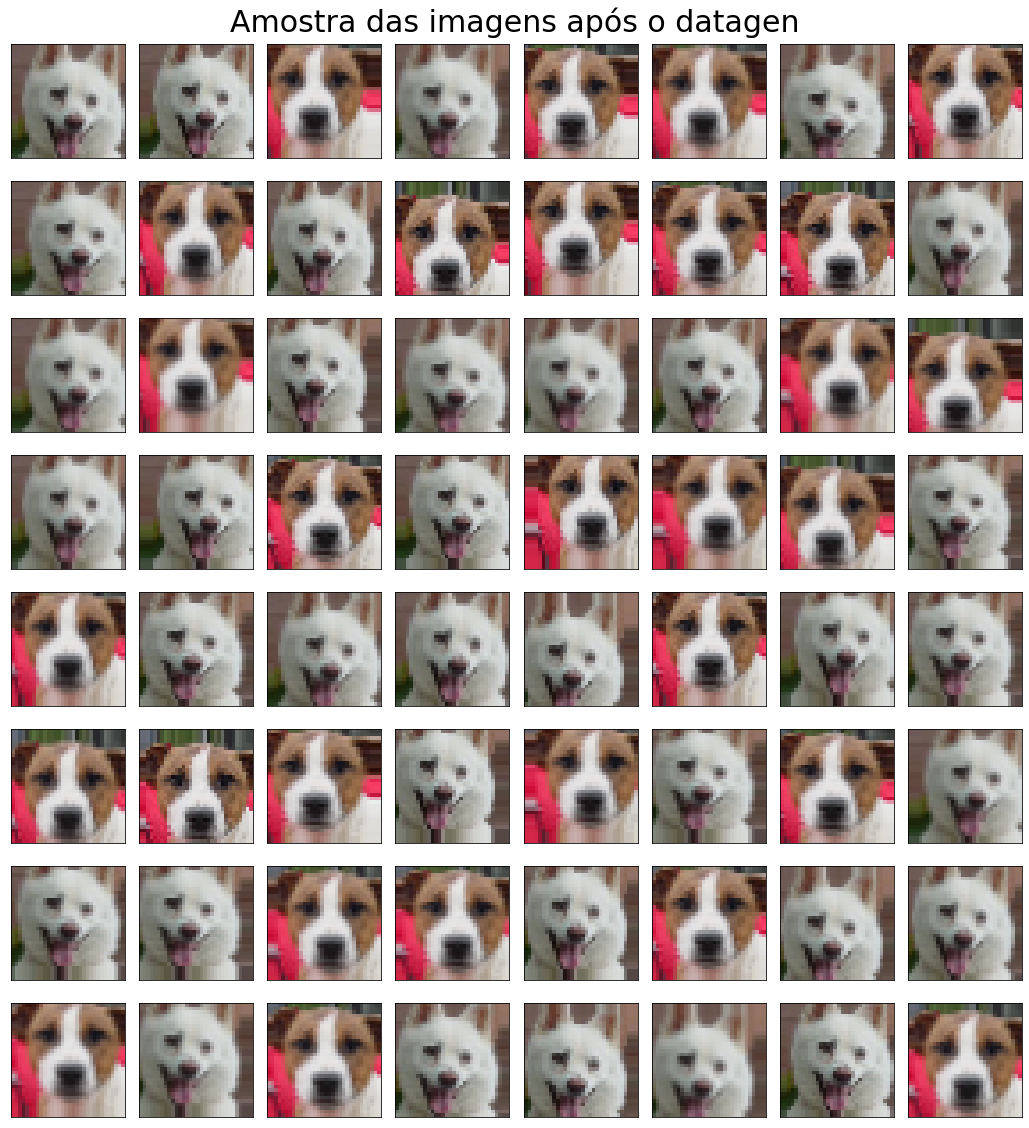

In [18]:
def bloco():

    global random_seed, class_names, image_width, image_height, image_layers, X_train
    
    random_seed = 1290387
    
    src_dir = 'data'

    class_names = ['face1','face2']
    
    image_width=32
    image_height=32
    image_layers=3

    train_generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255, 
        #horizontal_flip=True, 
        rotation_range=0.05,         
        shear_range=0.05, 
        #zoom_range=0.05,
        width_shift_range=0.10,
        height_shift_range=0.10        
    )
    train = train_generator.flow_from_directory(
        directory=src_dir, 
        class_mode='input',
        batch_size=40, 
        seed=random_seed, 
        shuffle=True,
        target_size=(image_width,image_height)
    )    

    X_train = next(train)[0]
    for i in range(10):
        X_train = np.vstack((X_train,next(train)[0]))        

    X_train = X_train.reshape((len(X_train),image_width*image_height*image_layers))
    print(X_train.shape) 

bloco()

def bloco():

    import matplotlib.pyplot as plt
               
    szx = 8
    szy = 8
    fig, axs = plt.subplots( szy,szx, figsize=[szx*1.8,szy*2] )
    axs = axs.flatten()
    for i, ax in enumerate(axs):            
        ax.imshow(X_train[i].reshape(image_width,image_height,image_layers))
        ax.set_xticks( [] )
        ax.set_yticks( [] )
        ax.grid( False )
        #ax.set_xlabel( class_names[ np.argmax(y[i],axis=0) ] )
        
    plt.suptitle('Amostra das imagens após o datagen',size=30)    
    plt.tight_layout()      
               
bloco()

# Construção do Modelo

In [19]:
def bloco():

  global vae, encoder, decoder

  espaco_latente_dimensoes=1
  
    # encoder: modelo padrão
  encoder_layer_input = tensorflow.keras.layers.Input(
      shape=( image_width * image_height * image_layers ), 
      name='encoder_layer_input'
    )
  encoder_layer_x1 = tensorflow.keras.layers.Dense(
      512, # quantidade de neurônios
      activation='sigmoid',
      name='encoder_layer_x1'
    )(encoder_layer_input)
  encoder_layer_x2 = tensorflow.keras.layers.Dense(
      512, # quantidade de neurônios
      activation='sigmoid',
      name='encoder_layer_x2'
    )(encoder_layer_x1)
  encoder_layer_mean = tensorflow.keras.layers.Dense(
      espaco_latente_dimensoes, # quantidade de neurônios
      name='encoder_layer_mean'
    )(encoder_layer_x2)
  encoder_layer_logvar = tensorflow.keras.layers.Dense(
      espaco_latente_dimensoes, # quantidade de neurônios
      name='encoder_layer_var'
    )(encoder_layer_x2)

  # reparameterization trick
  # ao invés de amostrar de Q(z|X), amostra epsilon = N(0,I)
  # z = z_mean + sqrt(var) * epsilon
  def sampling(args):
      z_mean, z_log_var = args
      batch = K.shape(z_mean)[0]
      dim = K.int_shape(z_mean)[1]
      # por padrão, a normal tem média 0 e desvio padrão unitário
      epsilon = K.random_normal(shape=(batch, dim))
      return z_mean + K.exp(0.5 * z_log_var) * epsilon      

  encoder_layer_z = tensorflow.keras.layers.Lambda(sampling, output_shape=(espaco_latente_dimensoes,), name='encoder_layer_z')([encoder_layer_mean, encoder_layer_logvar])

  # instancia o modelo do encoder
  encoder = tensorflow.keras.Model(encoder_layer_input, [encoder_layer_mean, encoder_layer_logvar, encoder_layer_z], name='encoder')
  encoder.summary()

  # constrói o modelo do decoder
  decoder_layer_input = tensorflow.keras.layers.Input(
      shape=(espaco_latente_dimensoes), 
      name='decoder_layer_input'
    )  
  decoder_layer_x1 = tensorflow.keras.layers.Dense(
      512, # quantidade de neurônios
      activation='sigmoid',
      name="decoder_layer_x1"
    )(decoder_layer_input)
  decoder_layer_x2 = tensorflow.keras.layers.Dense(
      512, # quantidade de neurônios
      activation='sigmoid',
      name="decoder_layer_x2"
    )(decoder_layer_x1)  
  decoder_layer_output = tensorflow.keras.layers.Dense(
      image_width*image_height*image_layers, # quantidade de neurônios
      activation='sigmoid',
      name="decoder_layer_output"
    )(decoder_layer_x2)

  # instancia o modelo do decoder
  decoder = tensorflow.keras.Model(decoder_layer_input, decoder_layer_output, name='decoder')
  decoder.summary()

  # instancia o modelo VAE
  outputs = decoder(encoder(encoder_layer_input)[2])
  vae = tensorflow.keras.Model(encoder_layer_input, outputs, name='vae_mlp')

  vae.summary()


  # VAE loss = xent_loss + kl_loss
  reconstruction_loss = tensorflow.keras.losses.binary_crossentropy(encoder_layer_input, outputs)
  reconstruction_loss *= image_width * image_height * image_layers

  # Apêndice B de https://arxiv.org/abs/1312.6114
  negative_kl_loss = 1 + encoder_layer_logvar - K.square(encoder_layer_mean) - K.exp(encoder_layer_logvar)
  negative_kl_loss = K.sum(negative_kl_loss, axis=-1)
  kl_loss = -0.5 * negative_kl_loss
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  vae.add_loss(vae_loss)
  vae.compile(optimizer='adam')

bloco()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_layer_input (InputLayer [(None, 3072)]       0                                            
__________________________________________________________________________________________________
encoder_layer_x1 (Dense)        (None, 512)          1573376     encoder_layer_input[0][0]        
__________________________________________________________________________________________________
encoder_layer_x2 (Dense)        (None, 512)          262656      encoder_layer_x1[0][0]           
__________________________________________________________________________________________________
encoder_layer_mean (Dense)      (None, 1)            513         encoder_layer_x2[0][0]           
____________________________________________________________________________________________

In [20]:
# treina o autoencoder
K.set_value(vae.optimizer.learning_rate, 0.001)
#K.set_value(vae.optimizer.learning_rate, 0.00001)

vae.fit(
    X_train,
    epochs=1000,
    #steps_per_epoch=len(X_train)/400,
    batch_size=len(X_train),
    #validation_data=(X_train, None)
  )

Epoch 1/1000
1/1 [==============================] - 1s 925ms/step - loss: 2157.8931
Epoch 2/1000
1/1 [==============================] - 0s 42ms/step - loss: 2081.8201
Epoch 3/1000
1/1 [==============================] - 0s 42ms/step - loss: 2042.9161
Epoch 4/1000
1/1 [==============================] - 0s 44ms/step - loss: 2026.2604
Epoch 5/1000
1/1 [==============================] - 0s 43ms/step - loss: 2022.5459
Epoch 6/1000
1/1 [==============================] - 0s 43ms/step - loss: 2021.8182
Epoch 7/1000
1/1 [==============================] - 0s 45ms/step - loss: 2019.6503
Epoch 8/1000
1/1 [==============================] - 0s 53ms/step - loss: 2016.5880
Epoch 9/1000
1/1 [==============================] - 0s 52ms/step - loss: 2014.0889
Epoch 10/1000
1/1 [==============================] - 0s 47ms/step - loss: 2012.9337
Epoch 11/1000
1/1 [==============================] - 0s 46ms/step - loss: 2013.0840
Epoch 12/1000
1/1 [==============================] - 0s 45ms/step - loss: 2013.7534


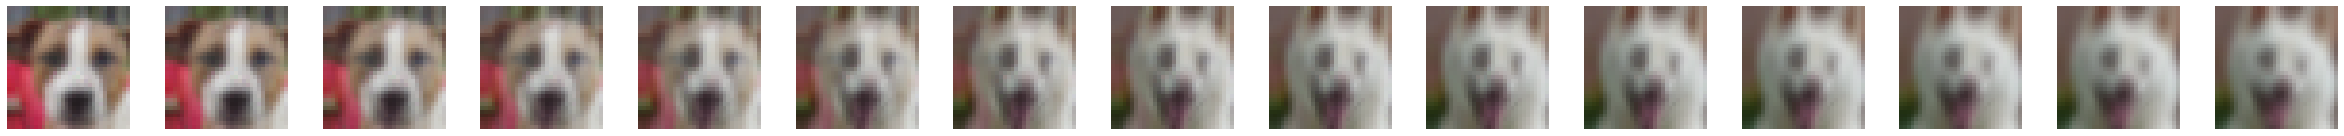

In [25]:
def bloco():

    import matplotlib.pyplot as plt

    steps=15

    fig, axs = plt.subplots(ncols=steps,nrows=1,figsize=(steps*2.2,2))      
    for i, p in enumerate(np.linspace(0,1,steps)):        
        ax = axs[i]
        img = decoder.predict( np.array([[p]]) )[0]
        ax.set_axis_off()
        ax.imshow(img.reshape(image_width,image_height,image_layers))      

    plt.tight_layout()     


bloco()